In [79]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import random as rnd

L1_SIZE = 56
L2_SIZE = 28
IMAGE_EDGE_SIZE = 28
PIXELS_PER_IMAGE = IMAGE_EDGE_SIZE ** 2
CLASSES_COUNT = 10
ITERATIONS = 500
LEARNING_RATE = 0.15

### Helper functions

In [80]:
def one_hot(labels):
    one_hot = np.zeros((labels.size, 10))
    one_hot[np.arange(labels.size), labels] = 1
    return one_hot.T

def get_accuracy(results, labels):
    return (np.sum(np.argmax(results, 0) == labels) / labels.size)

def show_some_mistakes(results, labels, data, samples = 10):
    results = np.argmax(results, 0)
    i = rnd.randint(0, labels.size)
    j = 0
    while j < samples:
        i = (i + 1) % labels.size
        if results[i] != labels[i]:
            print("labeled:", labels[i], "-- classified:", results[i])
            plt.imshow(data[:, i].reshape((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE)), cmap='gray')
            plt.show()
            j += 1

def assess_2L():
    W1 = np.load("W1_2L.npy")
    W2 = np.load("W2_2L.npy")
    B1 = np.load("B1_2L.npy")
    B2 = np.load("B2_2L.npy")
    print("\n###################### 2 layers results ######################\n")

    training_data, training_labels = load_training_data()
    L1, L2 = forward_prop_2L(W1, W2, B1, B2, training_data)
    print("Accuracy on training set: ", get_accuracy(L2, training_labels))

    test_data, test_labels = load_test_data()
    L1, L2 = forward_prop_2L(W1, W2, B1, B2, test_data)
    print("Accuracy on test set: ", get_accuracy(L2, test_labels))

    show_some_mistakes(L2, test_labels, test_data)

def assess_3L():
    W1 = np.load("W1_3L.npy")
    W2 = np.load("W2_3L.npy")
    W3 = np.load("W3_3L.npy")
    B1 = np.load("B1_3L.npy")
    B2 = np.load("B2_3L.npy")
    B3 = np.load("B3_3L.npy")
    print("\n###################### 3 layers results ######################\n")

    training_data, training_labels = load_training_data()
    L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
    print("Accuracy on training set: ", get_accuracy(L3, training_labels))

    test_data, test_labels = load_test_data()
    L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, test_data)
    print("Accuracy on test set: ", get_accuracy(L3, test_labels))

    show_some_mistakes(L3, test_labels, test_data)

### Non linear functions

In [81]:
def ReLU(L):
    return np.maximum(0, L)

def softmax(L):
    return np.exp(L) / sum(np.exp(L))

def sigmoid(L):
    return 1 / (1 + np.exp(-L))

def ReLU_deriv(L):
    return L != 0

### Initialization of weights and biases

In [82]:
def weights_init_2L(size, start_size = PIXELS_PER_IMAGE, end_size = CLASSES_COUNT):
    W1 = np.random.rand(size, start_size) - 0.5
    W2 = np.random.rand(end_size, size) - 0.5
    return W1, W2

def weights_init_3L(l1_size, l2_size, start_size = PIXELS_PER_IMAGE, end_size = CLASSES_COUNT):
    W1 = np.random.rand(l1_size, start_size) - 0.5
    W2 = np.random.rand(l2_size, l1_size) - 0.5
    W3 = np.random.rand(end_size, l2_size) - 0.5
    return W1, W2, W3

def weights_init(sizes):
    weights = []
    for i in range(len(sizes) - 1):
        weights.append(np.random.rand(sizes[i + 1], sizes[i]) - 0.5)
    return weights

def biases_init_2L(size, end_size = 10):
    B1 = np.random.rand(size, 1) - 0.5
    B2 = np.random.rand(end_size, 1) - 0.5
    return B1, B2

def biases_init_3L(l1_size, l2_size, end_size = CLASSES_COUNT):
    B1 = np.random.rand(l1_size, 1) - 0.5
    B2 = np.random.rand(l2_size, 1) - 0.5
    B3 = np.random.rand(end_size, 1) - 0.5
    return B1, B2, B3

def biases_init(sizes):
    biases = []
    for i in range(1, len(sizes)):
        biases.append(np.random.rand(sizes[i], 1) - 0.5)
    return biases

### Adjusting weights and biases after a training cycle

In [83]:
def weights_adjust_2L(W1, W2, dW1, dW2, learning_rate):
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    return W1, W2

def weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate):
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    W3 = W3 - learning_rate * dW3
    return W1, W2, W3

def weights_adjust(weights, weight_derivs, learning_rate):
    for i in range(len(weights)):
        weights[i] = weights[i] - learning_rate * weight_derivs[i]

def biases_adjust_2L(B1, B2, dB1, dB2, learning_rate):
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    return B1, B2

def biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate):
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    B3 = B3 - learning_rate * dB3
    return B1, B2, B3

def biases_adjust(biases, bias_derivs, learning_rate):
    for i in range(len(biases)):
        biases[i] = biases[i] - learning_rate * bias_derivs[i]

### Forward and backward propagation

In [84]:
def forward_prop_2L(W1, W2, B1, B2, training_data):
    Z1 = W1.dot(training_data) + B1
    L1 = ReLU(Z1)
    Z2 = W2.dot(L1) + B2
    L2 = softmax(Z2)
    return L1, L2

def forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data):
    Z1 = W1.dot(training_data) + B1
    L1 = ReLU(Z1)
    Z2 = W2.dot(L1) + B2
    L2 = ReLU(Z2)
    Z3 = W3.dot(L2) + B3
    L3 = softmax(Z3)
    return L1, L2, L3

def forward_prop(weights, biases, activations, training_data):
    layers = []
    input = training_data
    for i in range(len(weights)):
        layers.append(activations[i](weights[i].dot(input) + biases[i]))
        input = layers[i]
    
    return layers

def back_prop_2L(L1, L2, W2, training_data, one_hot_labels):
    normalization = one_hot_labels.shape[1]
    dZ2 = L2 - one_hot_labels
    dW2 = dZ2.dot(L1.T) / normalization
    dB2 = np.sum(dZ2) / normalization
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(L1)
    dW1 = dZ1.dot(training_data.T) / normalization
    dB1 = np.sum(dZ1) / normalization
    return dW1, dW2, dB1, dB2

def back_prop_3L(L1, L2, L3, W2, W3, training_data, one_hot_labels):
    normalization = one_hot_labels.shape[1]
    dZ3 = L3 - one_hot_labels
    dW3 = dZ3.dot(L2.T) / normalization
    dB3 = np.sum(dZ3) / normalization
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(L2)
    dW2 = dZ2.dot(L1.T) / normalization
    dB2 = np.sum(dZ2) / normalization
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(L1)
    dW1 = dZ1.dot(training_data.T) / normalization
    dB1 = np.sum(dZ1) / normalization
    return dW1, dW2, dW3, dB1, dB2, dB3

def back_prop(layers, weights, activation_derivs, training_data, one_hot_labels):
    layers_count = len(layers)
    normalization = one_hot_labels.shape[1]
    weight_derivs = [None] * layers_count
    bias_derivs = [None] * layers_count

    current_deriv = layers[layers_count - 1] - one_hot_labels
    for i in range(layers_count - 1, 0, -1):
        weight_derivs[i] = current_deriv.dot(layers[i - 1].T) / normalization
        bias_derivs[i] = np.sum(current_deriv) / normalization
        current_deriv = weights[i].T.dot(current_deriv) * activation_derivs[i - 1](layers[i - 1])
        
    weight_derivs[0] = current_deriv.dot(training_data.T) / normalization
    bias_derivs[0] = np.sum(current_deriv) / normalization

    return weight_derivs, bias_derivs

### Gradient descend

In [85]:
def gradient_descend_2L(training_data, labels, iterations = ITERATIONS, learning_rate = LEARNING_RATE, L1_size = L1_SIZE):
    W1, W2 = weights_init_2L(L1_size)
    B1, B2 = biases_init_2L(L1_size)
    labels = one_hot(labels)

    for _ in range(iterations):
        L1, L2 = forward_prop_2L(W1, W2, B1, B2, training_data)
        dW1, dW2, dB1, dB2 = back_prop_2L(L1, L2, W2, training_data, labels)
        W1, W2 = weights_adjust_2L(W1, W2, dW1, dW2, learning_rate)
        B1, B2 = biases_adjust_2L(B1, B2, dB1, dB2, learning_rate)

    return W1, W2, B1, B2

def gradient_descend_3L(training_data, labels, iterations = ITERATIONS, learning_rate = LEARNING_RATE, L1_size = L1_SIZE, L2_size = L2_SIZE):
    W1, W2, W3 = weights_init_3L(L1_size, L2_size)
    B1, B2, B3 = biases_init_3L(L1_size, L2_size)
    labels = one_hot(labels)

    for _ in range(iterations):
        L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
        dW1, dW2, dW3, dB1, dB2, dB3 = back_prop_3L(L1, L2, L3, W2, W3, training_data, labels)
        W1, W2, W3 = weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate)
        B1, B2, B3 = biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate)

    return W1, W2, W3, B1, B2, B3

def gradient_descend(weight_sizes, activations, activation_derivs, training_data, labels, iterations = ITERATIONS, learning_rate = LEARNING_RATE):
    weights = weights_init(weight_sizes)
    biases = biases_init(weight_sizes)
    labels = one_hot(labels)

    for _ in range(iterations):
        layers = forward_prop(weights, biases, activations, training_data)
        weight_derivs, bias_derivs = back_prop(layers, weights, activation_derivs, training_data, labels)
        weights = weights_adjust(weights, weight_derivs, learning_rate)
        biases = biases_adjust(biases, bias_derivs, learning_rate)

    return weights, biases

### Training functions

In [86]:
def train_3L(training_data, training_labels, iterations, learning_rate):
    W1, W2, W3, B1, B2, B3 = gradient_descend_3L(training_data, training_labels, iterations, learning_rate)

    np.save("W1_3L.npy", W1)
    np.save("W2_3L.npy", W2)
    np.save("W3_3L.npy", W3)
    np.save("B1_3L.npy", B1)
    np.save("B2_3L.npy", B2)
    np.save("B3_3L.npy", B3)

def train_2L(training_data, training_labels, iterations, learning_rate):
    W1, W2, B1, B2 = gradient_descend_2L(training_data, training_labels, iterations, learning_rate)

    np.save("W1_2L.npy", W1)
    np.save("W2_2L.npy", W2)
    np.save("B1_2L.npy", B1)
    np.save("B2_2L.npy", B2)

### Loading of training and testing data

In [87]:
def load_training_data():
    training_data = idx2numpy.convert_from_file("mnist/train-images.idx3-ubyte")
    training_labels = idx2numpy.convert_from_file("mnist/train-labels.idx1-ubyte")
    sample_count = training_data.shape[0]
    training_data = np.reshape(training_data, (sample_count, -1)).T / 255
    return training_data, training_labels

def load_test_data():
    test_data = idx2numpy.convert_from_file("mnist/t10k-images.idx3-ubyte")
    test_labels = idx2numpy.convert_from_file("mnist/t10k-labels.idx1-ubyte")
    sample_count = test_data.shape[0]
    test_data = np.reshape(test_data, (sample_count, -1)).T / 255
    return test_data, test_labels

### Training

In [88]:
training_data, training_labels = load_training_data()
#train_3L(training_data, training_labels)
#train_2L(training_data, training_labels, 50)

### Result assessment


###################### 2 layers results ######################

Accuracy on training set:  0.77495
Accuracy on test set:  0.7832
labeled: 9 -- classified: 7


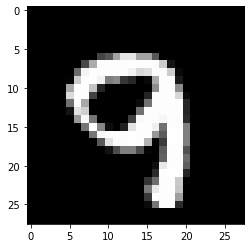

labeled: 9 -- classified: 4


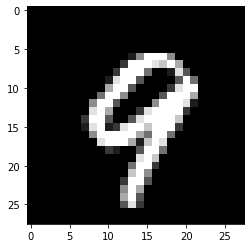

labeled: 7 -- classified: 9


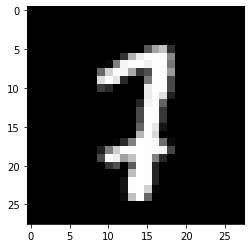

labeled: 5 -- classified: 9


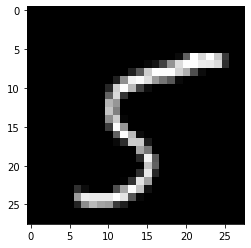

labeled: 4 -- classified: 5


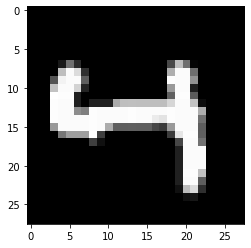

labeled: 2 -- classified: 8


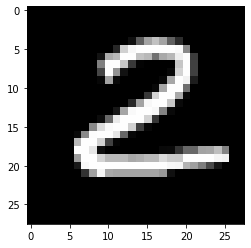

labeled: 8 -- classified: 3


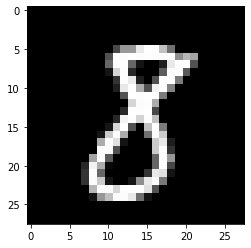

labeled: 4 -- classified: 1


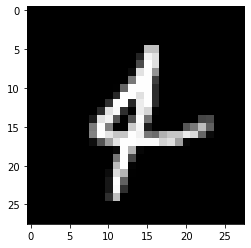

labeled: 7 -- classified: 9


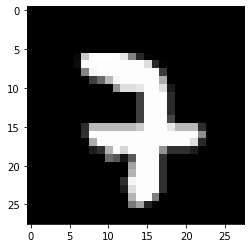

labeled: 2 -- classified: 7


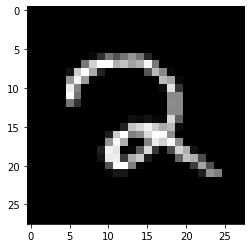


###################### 3 layers results ######################

Accuracy on training set:  0.9107333333333333
Accuracy on test set:  0.9117
labeled: 7 -- classified: 9


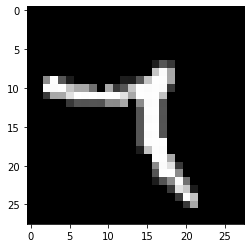

labeled: 9 -- classified: 4


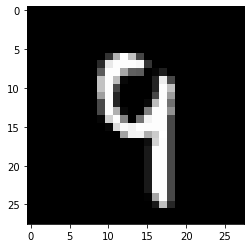

labeled: 9 -- classified: 4


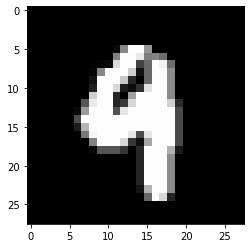

labeled: 9 -- classified: 4


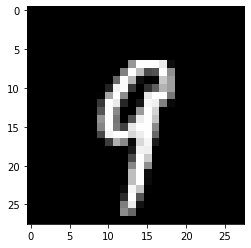

labeled: 2 -- classified: 3


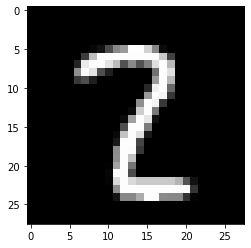

labeled: 7 -- classified: 3


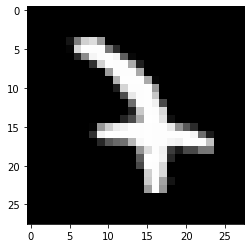

labeled: 3 -- classified: 7


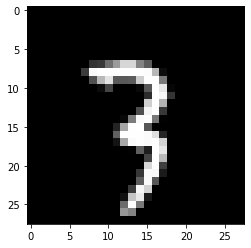

labeled: 4 -- classified: 9


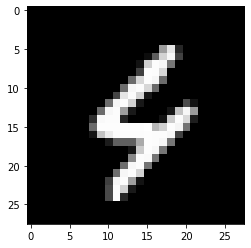

labeled: 6 -- classified: 0


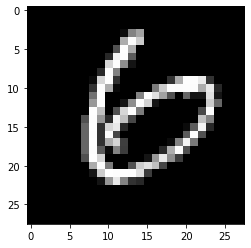

labeled: 2 -- classified: 8


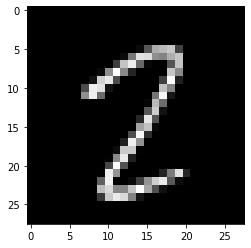

In [89]:
assess_2L()
assess_3L()

In [90]:
for i in range(5, -1, -1):
    print(i)

5
4
3
2
1
0
